In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plot style settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Paden
raw_data_path = os.path.join("data", "uk_housing", "raw", "price_paid_records.csv")

print("Libraries geladen.")

Libraries geladen.


# Notebook 02: Cleaning & Exploratory Data Analysis (EDA)

**Auteur:** Natan Wojtowicz

## Doel
In dit notebook laden we de ruwe data (gevalideerd in notebook 01). We gaan de data opschonen, types optimaliseren (belangrijk voor de grootte), missende waarden aanpakken en visualisaties maken om trends in de huizenmarkt te ontdekken.

## Stappenplan
1.  **Laden & Optimaliseren:** Data inladen met correcte headers en datatypes.
2.  **Cleaning:** Na-waarden en inconsistenties behandelen.
3.  **Outliers:** Extremen identificeren en filteren.
4.  **EDA:** Visualisaties van prijstrends, property types en locaties.

### 1. Data Laden
De dataset is erg groot (>2GB). Om geheugen te besparen:
1.  Definiëren we kolomnamen meteen bij het inladen.
2.  Converteren we tekstkolommen direct naar `category`. Dit bespaart enorm veel geheugen vergeleken met `object` (string).

In [3]:
# Kolomnamen (lowercase en underscores zoals gevraagd)
cols = [
    "transaction_id", "price", "date_of_transfer", "property_type", 
    "old_new", "duration", "town_city", "district", 
    "county", "ppd_category", "record_status"
]

print("Start laden van dataset... (dit kan even duren)")

# AANGEPAST: header=0 zorgt dat de originele header-rij niet als data wordt ingelezen
df = pd.read_csv(
    raw_data_path, 
    names=cols,
    header=0,  # <-- BELANGRIJK: Dit was None. 0 betekent: negeer de originele header rij.
    parse_dates=["date_of_transfer"]
)

print(f"Originele dataset grootte in geheugen: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Even checken of prijs nu wel een getal is
# We forceren prijs naar numeric, fouten worden NaN (voor de zekerheid)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Type conversie voor geheugenbesparing (Object -> Category)
cat_cols = ["property_type", "old_new", "duration", "town_city", "district", "county", "ppd_category", "record_status"]

for col in cat_cols:
    df[col] = df[col].astype("category")

print(f"Geoptimaliseerde grootte in geheugen: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Laat de eerste regels zien - NU ZONDER de tekst header in rij 0
display(df.head())
print("\nDatatypes:")
print(df.dtypes)

Start laden van dataset... (dit kan even duren)
Originele dataset grootte in geheugen: 11395.78 MB
Geoptimaliseerde grootte in geheugen: 2445.17 MB


,transaction_id,price,date_of_transfer,property_type,old_new,duration,town_city,district,county,ppd_category,record_status
0,{81B82214-7FBC-4129-9F6B-4956B4A663AD},25000,1995-08-18,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,A,A
1,{8046EC72-1466-42D6-A753-4956BF7CD8A2},42500,1995-08-09,S,N,F,GRAYS,THURROCK,THURROCK,A,A
2,{278D581A-5BF3-4FCE-AF62-4956D87691E6},45000,1995-06-30,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,A,A
3,{1D861C06-A416-4865-973C-4956DB12CD12},43150,1995-11-24,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,A,A
4,{DD8645FD-A815-43A6-A7BA-4956E58F1874},18899,1995-06-23,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,A,A



Datatypes:
transaction_id              object
price                        int64
date_of_transfer    datetime64[ns]
property_type             category
old_new                   category
duration                  category
town_city                 category
district                  category
county                    category
ppd_category              category
record_status             category
dtype: object


### 2. Data Cleaning: Missing Values (NA)
We controleren welke kolommen data missen. Als er steden of districten ontbreken, vullen we die op of verwijderen we de rijen, afhankelijk van de impact.

In [4]:
# Check missing values
print("Aantal missing values per kolom:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Visualisatie van missing values (optioneel, als er veel zijn)
if missing.sum() > 0:
    plt.figure(figsize=(10,4))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title("Heatmap van Missing Values")
    plt.show()

# Actie: Drop rijen waar essentiële info ontbreekt (bijv. Datum of Prijs)
# Voor locatie kolommen (Town/City etc) vullen we NA met 'UNKNOWN' omdat we de prijsdata niet willen verliezen.
# Let op: Voor categories moeten we 'UNKNOWN' eerst toevoegen aan de categorie-lijst.

columns_to_fill = ['town_city', 'district', 'county']

for col in columns_to_fill:
    if df[col].isnull().sum() > 0:
        if 'UNKNOWN' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories('UNKNOWN')
        df[col] = df[col].fillna('UNKNOWN')
        print(f"NA waarden in '{col}' gevuld met 'UNKNOWN'")

print("\nCheck na cleaning:")
print(df.isnull().sum())

Aantal missing values per kolom:
Series([], dtype: int64)

Check na cleaning:
transaction_id      0
price               0
date_of_transfer    0
property_type       0
old_new             0
duration            0
town_city           0
district            0
county              0
ppd_category        0
record_status       0
dtype: int64


### 3. Outliers en Logica
Huizenprijzen kunnen extreem variëren.
* Extreem lage prijzen (bijv. < £100) zijn waarschijnlijk fouten of overdrachten binnen familie.
* Extreem hoge prijzen (miljoenen) kunnen kloppen, maar beïnvloeden modellen sterk.

We bekijken de verdeling met een Boxplot en Histogram.

count    22489348.00
mean       178244.21
std        390367.65
min             1.00
25%         75000.00
50%        130000.00
75%        210000.00
max      98900000.00
Name: price, dtype: float64


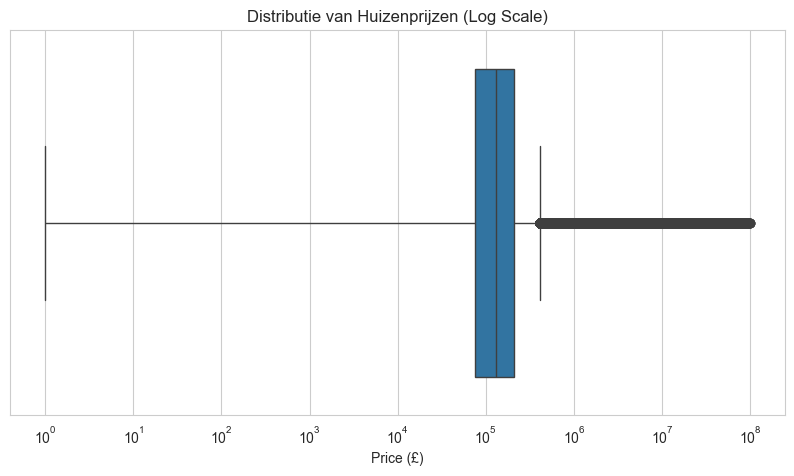

In [5]:
# Statistische samenvatting van de prijs
print(df['price'].describe().round(2))

# Boxplot (Log scale om het leesbaar te houden)
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['price'])
plt.xscale('log') # Logaritmische schaal omdat het verschil tussen min en max enorm is
plt.title("Distributie van Huizenprijzen (Log Scale)")
plt.xlabel("Price (£)")
plt.show()

In [6]:
# Definieer grenzen (Experimenteer hier mee!)
min_price = 1000       # Alles onder 1000 pond is verdacht
max_price = 10000000   # Alles boven 10 miljoen beschouwen we als outlier voor het algemene model

initial_rows = len(df)

# Filteren
df_clean = df[(df['price'] >= min_price) & (df['price'] <= max_price)].copy()

removed_rows = initial_rows - len(df_clean)
print(f"Rijen verwijderd: {removed_rows} ({(removed_rows/initial_rows)*100:.2f}%)")
print(f"Resterende dataset grootte: {len(df_clean)}")

Rijen verwijderd: 4748 (0.02%)
Resterende dataset grootte: 22484600


### 4. EDA: Trends over tijd
Hoe hebben de huizenprijzen zich ontwikkeld tussen 1995 en 2017?
We resamplen de data per maand om een duidelijke lijngrafiek te krijgen.

C:\Users\natan\AppData\Local\Temp\ipykernel_3168\1369181290.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_clean.set_index('date_of_transfer').resample('M')['price'].mean()


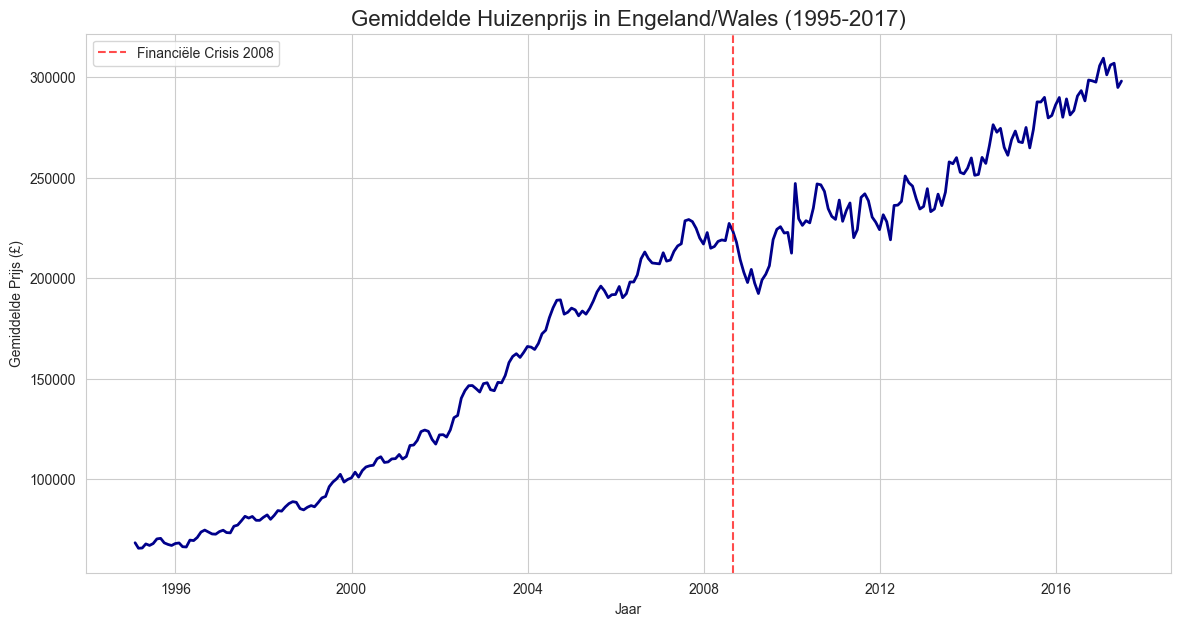

In [7]:
# Voeg Jaar en Maand toe voor makkelijk groeperen
df_clean['year'] = df_clean['date_of_transfer'].dt.year

# Bereken gemiddelde prijs per maand
monthly_avg = df_clean.set_index('date_of_transfer').resample('M')['price'].mean()

plt.figure(figsize=(14, 7))
plt.plot(monthly_avg.index, monthly_avg.values, color='darkblue', linewidth=2)
plt.title("Gemiddelde Huizenprijs in Engeland/Wales (1995-2017)", fontsize=16)
plt.ylabel("Gemiddelde Prijs (£)")
plt.xlabel("Jaar")
# Markeer de crisis van 2008
plt.axvline(pd.Timestamp('2008-09-01'), color='red', linestyle='--', alpha=0.7, label='Financiële Crisis 2008')
plt.legend()
plt.show()

### 5. EDA: Woningtypes
Wat is de invloed van het type woning op de prijs?
* **D** = Detached (Vrijstaand)
* **S** = Semi-Detached (Twee-onder-een-kap)
* **T** = Terraced (Rijtjeshuis)
* **F** = Flats/Maisonettes (Appartement)
* **O** = Other

C:\Users\natan\AppData\Local\Temp\ipykernel_3168\1066123349.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='property_label', order=df_clean['property_label'].value_counts().index, palette='viridis')
C:\Users\natan\AppData\Local\Temp\ipykernel_3168\1066123349.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_clean, x='property_label', y='price', order=df_clean['property_label'].value_counts().index, estimator=np.median, palette='viridis')


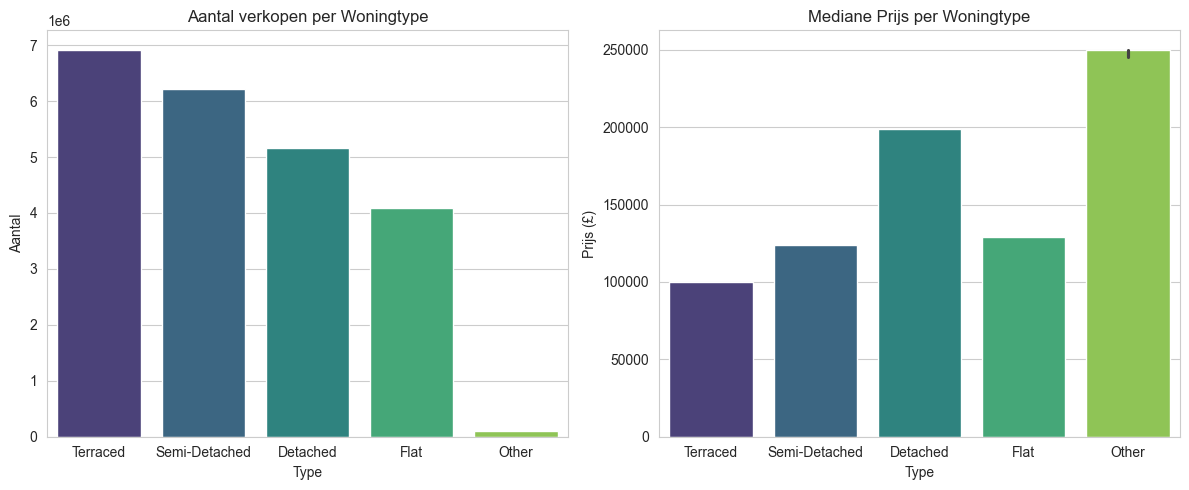

In [8]:
# Mapping voor duidelijkere labels in de grafiek
type_map = {'D': 'Detached', 'S': 'Semi-Detached', 'T': 'Terraced', 'F': 'Flat', 'O': 'Other'}
df_clean['property_label'] = df_clean['property_type'].map(type_map)

# Barplot van aantallen
plt.figure(figsize=(12, 5))

# Subplot 1: Aantal verkopen per type
plt.subplot(1, 2, 1)
sns.countplot(data=df_clean, x='property_label', order=df_clean['property_label'].value_counts().index, palette='viridis')
plt.title("Aantal verkopen per Woningtype")
plt.xlabel("Type")
plt.ylabel("Aantal")

# Subplot 2: Prijs per type
plt.subplot(1, 2, 2)
sns.barplot(data=df_clean, x='property_label', y='price', order=df_clean['property_label'].value_counts().index, estimator=np.median, palette='viridis')
plt.title("Mediane Prijs per Woningtype")
plt.xlabel("Type")
plt.ylabel("Prijs (£)")

plt.tight_layout()
plt.show()

### Conclusie & Export
We hebben de data opgeschoond (outliers verwijderd, types verbeterd) en verkend.
De belangrijkste bevindingen:
1.  Duidelijke stijgende trend, met een dip rond 2008.
2.  'Detached' woningen zijn aanzienlijk duurder.
3.  Londen (Greater London) en omliggende counties zijn het duurst.

We slaan de opgeschoonde dataset op als **Parquet** bestand. Parquet is veel sneller en kleiner dan CSV, en behoudt de datatypes (zoals categories), wat cruciaal is voor het volgende modelleer-notebook.

In [19]:
# Map aanmaken voor processed data
processed_dir = os.path.join("data", "uk_housing", "processed")
os.makedirs(processed_dir, exist_ok=True)

output_path = os.path.join(processed_dir, "housing_clean.parquet")

print("Bezig met opslaan naar Parquet...")
# We verwijderen tijdelijke kolommen (zoals year en property_label) om de set clean te houden voor modeling
cols_to_drop = ['year', 'property_label']
df_final = df_clean.drop(columns=cols_to_drop)

df_final.to_parquet(output_path, index=False)
print(f"Opgeslagen in: {output_path}")

Bezig met opslaan naar Parquet...
Opgeslagen in: data\uk_housing\processed\housing_clean.parquet
